## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
!{sys.executable} --version

Python 3.7.6


In [7]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/Users/dps/.fastai/data/planet')

In [4]:
# ! {sys.executable} -m pip install kaggle --upgrade

In [5]:
!chmod 600 /Users/dps/.kaggle/kaggle.json

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar -p {path}
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar -p {path}

In [ ]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

In [ ]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [8]:
!ls {path}

Kaggle-planet-test-tif.torrent  test_v2_file_mapping.csv
Kaggle-planet-train-tif.torrent train-jpg
sample_submission_v2.csv        train-jpg.tar.7z
test-jpg.tar.7z                 train_v2.csv


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [9]:
import os
os.path.abspath('.')

'/Users/dps/Desktop/dlff-note/nbs/dl1'

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [10]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/Users/dps/.fastai/data/planet')

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

## Multiclassification

### [Pytorch dataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html) -  To make PyTorch tell about my data, we should *create* data first.
- `__getitem__` -> object[idx], i.e. idx'th item
- `__len__` -> len(object)

### [DataLoader](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html) - Takes a dataset, using batch_size(so that our GPU can work in parallel), make **mini_batch**
- Grab items at dataset randomly
- Create a batch (whatever size you asked for)
- pop it on the GPU
- send it off to your model for you

### [DataBunch](https://docs.fast.ai/data_block.html#Step-4:-convert-to-a-DataBunch)

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [11]:
df = pd.read_csv(path/'train_v2.csv', engine='python')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

- Example of [databunch](https://docs.fast.ai/data_block.html#Examples-of-use)

> what is flip_ver? max_lighting? ...?

In [12]:
tfms = get_transforms(flip_vert=True, #flip vertically
                      max_lighting=0.1,
                      max_zoom=1.05,
                      max_warp=0. #shape of the object)

but saterlite .. always flat -> 0.

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [13]:
# doc(ImageList)

In [14]:
np.random.seed(12)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [15]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

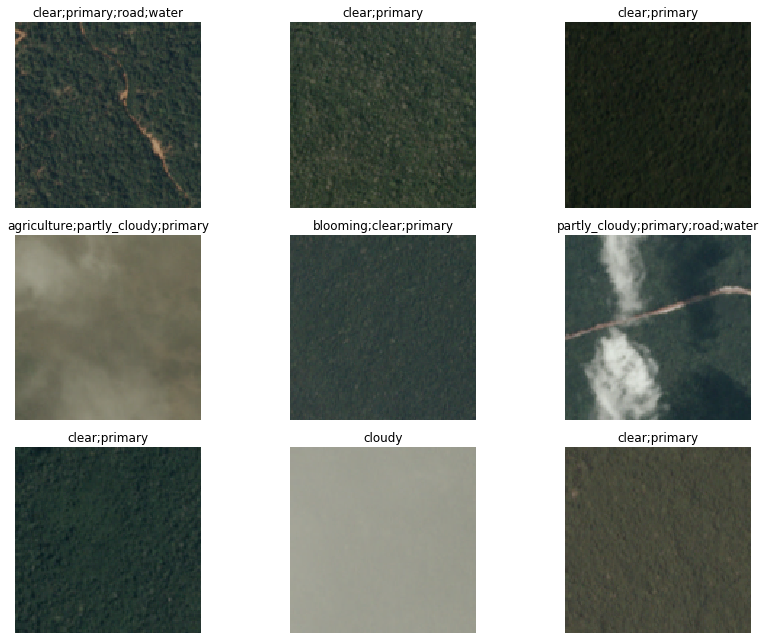

In [17]:
data.show_batch(rows=3, figsize=(12,9))

[data-block](https://docs.fast.ai/data_block.html#Examples-of-use), example of use

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [18]:
arch = models.resnet50

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, #architecture
                    metrics=[acc_02, f_score])

#### metrics

- has nothing to do with how the model trains, and changing my metrics does not change our model, at all.
- The only thing metric affects is when they print out the training
- If you want to know how to do better job, metrics doesn't help at all...
- Jeremy used f-scrore, cz he wanted to know kaggle score

We use the LR Finder to pick a good learning rate.

In [20]:
fbeta()

TypeError: fbeta() missing 2 required positional arguments: 'y_pred' and 'y_true'

In [ ]:
Signature:
fbeta(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    thresh: float = 0.2,
    beta: float = 2,
    eps: float = 1e-09,
    sigmoid: bool = True,
) -> <function NewType.<locals>.new_type at 0x1181d1950>
Docstring: Computes the f_beta between `preds` and `targets`
File:      /opt/anaconda3/envs/myenv-py37/lib/python3.7/site-packages/fastai/metrics.py
Type:      function

#### What is threshold?

In [21]:
accuracy??
Signature: accuracy(input: torch.Tensor, targs: torch.Tensor) -> <function NewType.<locals>.new_type at 0x1181d1950>
Source:   
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
File:      /opt/anaconda3/envs/myenv-py37/lib/python3.7/site-packages/fastai/metrics.py
Type:      function

[Accuracy we did last time](https://youtu.be/MpZxV6DVsmM?t=2263) -> there is one correct lable

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.save('stage-2-rn50')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

Private Leaderboard score: 0.9296 (around 80th)